In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
sys.path.insert(1, r'C:\Users\dexte\Documents\GitHub\pico_weight_scales')


/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## load data

In [2]:
folder_path=r"C:\Users\dexte\Documents\GitHub\pico_weight_scales\assets\data"
folder_path="/its/home/drs25/Documents/GitHub/pico_weight_scales/assets/data"
def load_and_label_sensor_csvs(folder_path):
    all_dfs = []

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, header=None)
            df.rename(columns={0: file.replace("grams_","").replace(".csv","")}, inplace=True)
            if type(all_dfs)==type([]):
                all_dfs=df
            else: all_dfs=pd.concat([all_dfs, df], axis=1)
    return all_dfs
df = load_and_label_sensor_csvs(folder_path)
if df is not None:
    print(df.head())    

         21        20         9        17         7        13         6  \
0  0.016113  0.020142  0.016919  0.018530  0.016113  0.016919  0.013697   
1  0.020142  0.019336  0.015308  0.017725  0.015308  0.017725  0.014502   
2  0.020142  0.020142  0.009668  0.018530  0.016113  0.021753  0.013697   
3  0.019336  0.021753  0.015308  0.024170  0.016113  0.019336  0.014502   
4  0.020142  0.021753  0.015308  0.022559  0.017725  0.020948  0.012891   

         40        11        28  ...        50        70         5         1  \
0  0.019336  0.019336  0.022559  ...  0.019336  0.020142  0.021753  0.012891   
1  0.016919  0.015308  0.020142  ...  0.016919  0.020142  0.013697  0.012891   
2  0.019336  0.016113  0.022559  ...  0.017725  0.020948  0.014502  0.013697   
3  0.020142  0.015308  0.022559  ...  0.017725  0.026587  0.013697  0.007251   
4  0.019336  0.016113  0.023365  ...  0.016919  0.013697  0.012891  0.013697   

         19        22         8        27       100        18  
0  0

## show data

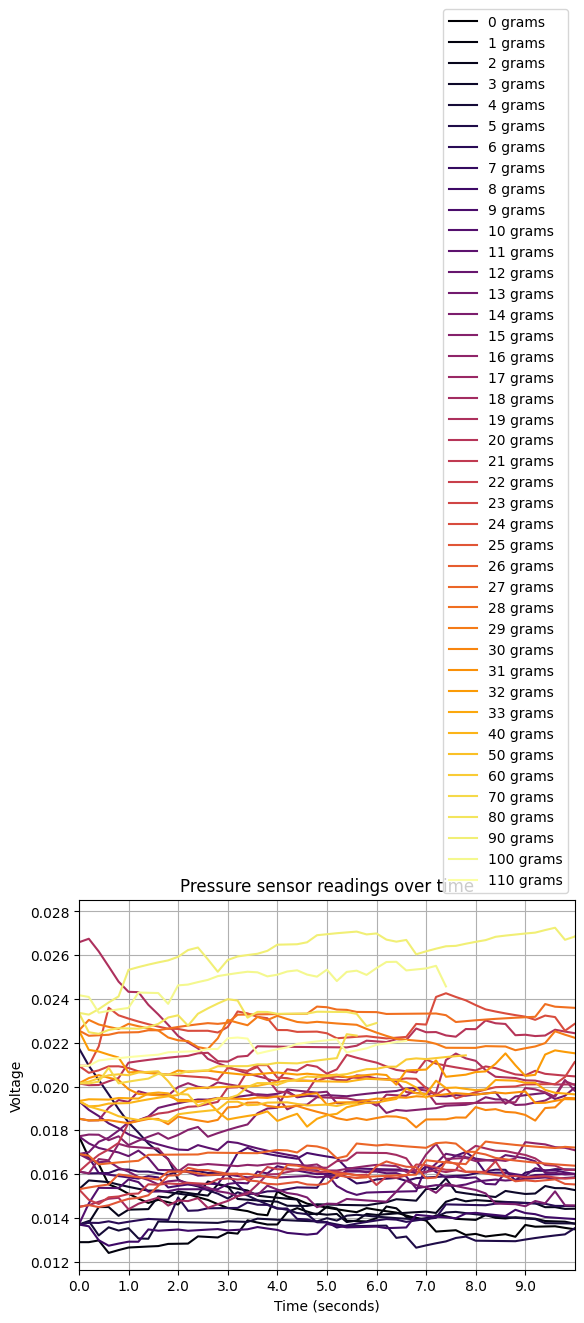

In [4]:
def low_pass(data,alpha=0.9):
    ar=[data[0]]
    for i in range(1,len(data)):
        ar.append(alpha*ar[i-1] + (1-alpha)*data[i])
    return np.array(ar)
keys=list(df.keys())
keys = sorted(keys, key=int)
colors = plt.cm.inferno(np.linspace(0, 1, len(keys)))  # Generate colors
X=[]
for i in range(len(keys)):
    key=keys[i]
    plt.plot(low_pass(df[key]),label=key+" grams", color=colors[i])
    x=np.array(low_pass(df[key]))
    X.append(np.average(x[~np.isnan(x)]))

plt.ylabel("Voltage")
plt.xlim([0,50])
plt.xticks([i for i in range(0,50,5)],[0.2*i for i in range(0,50,5)])
plt.grid(1)
plt.xlabel("Time (seconds)")
plt.legend(loc="lower right", bbox_to_anchor=(1, 1))
plt.title("Pressure sensor readings over time")
plt.show()

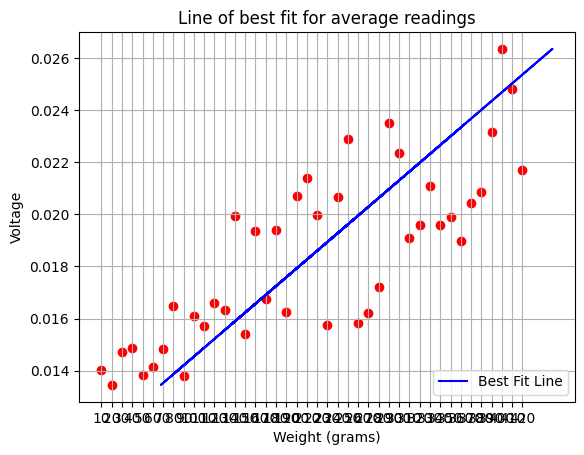

In [5]:
X=np.array(X)
y=np.array([i for i in range(len(X))])
m, b = np.polyfit(X,y, 1)

# Generate the best-fit line
Y_fit = m * X + b
def predict(value):
    Y_fit = m * value + b
    return Y_fit
plt.scatter([i for i in range(len(X))],X,c="r")
plt.xticks([i for i in range(len(X))],[((i+1)*10) for i in range(len(X))])
plt.plot(Y_fit,X, color="blue", label="Best Fit Line")  # Plot line
plt.title("Line of best fit for average readings")
plt.ylabel("Voltage")
plt.xlabel("Weight (grams)")
plt.grid(1)
plt.legend(loc="lower right")
plt.show()


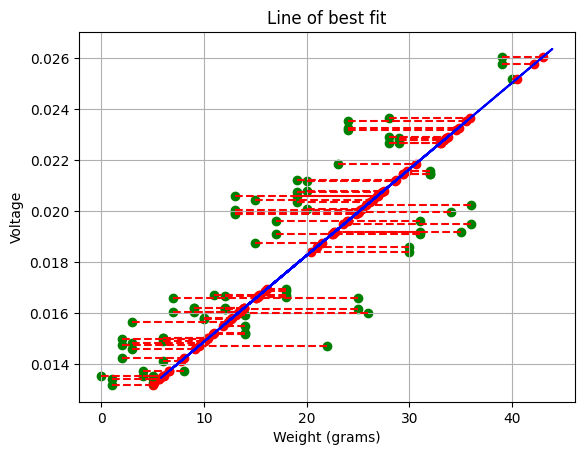

In [6]:
for i in range(len(keys)):
    key=keys[i]
    data=low_pass(df[key])
    for j in range(4):
        val=np.random.choice(data)
        pred=predict(val)
        plt.scatter(int(i),val, color="g")
        plt.scatter(pred, val, color="r")
        plt.plot([i,pred],[val,val],"--",c="r")

#plt.xticks([i for i in range(len(X))],[((i+1)*10) for i in range(len(X))])
plt.plot(Y_fit,X, color="blue", label="Best Fit Line")  # Plot line
plt.title("Line of best fit")
plt.ylabel("Voltage")
plt.xlabel("Weight (grams)")
plt.grid(1)
plt.show()


## regression

(1218,) (1218,)
Mean Squared Error: 360.3466364244507
Mean Squared Error: 313.0278345130451


Text(0.5, 1.0, 'Linear regression model predicting weight from voltage')

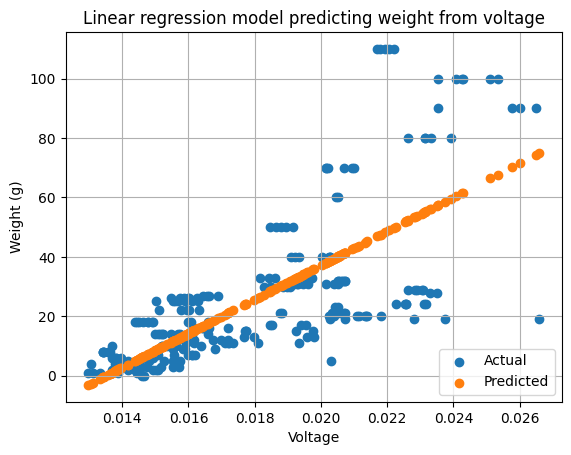

In [7]:
df=df.dropna()
X=np.array([])
y=np.array([])
for i in range(len(keys)):
    key=keys[i]
    vals=df[key].values
    vals=low_pass(vals)
    X=np.concatenate([X,vals])
    y=np.concatenate([y,np.array([int(key) for j in range(len(vals))])])
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.2, random_state=42) #this splits

#train the model
model = LinearRegression()
model.fit(X_train, y_train)

#work out how good the model is on the train data
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

#work out how good the model is on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test,y_test,label="Actual")
plt.scatter(X_test,y_pred,label="Predicted")
plt.grid(1)
plt.legend(loc="lower right")
plt.xlabel("Voltage")
plt.ylabel("Weight (g)")
plt.title("Linear regression model predicting weight from voltage")

(1218,) (1218,)
Mean Squared Error: 73.29528363334126
Mean Squared Error: 345.9276002961484


Text(0.5, 1.0, 'Linear regression model predicting weight from voltage')

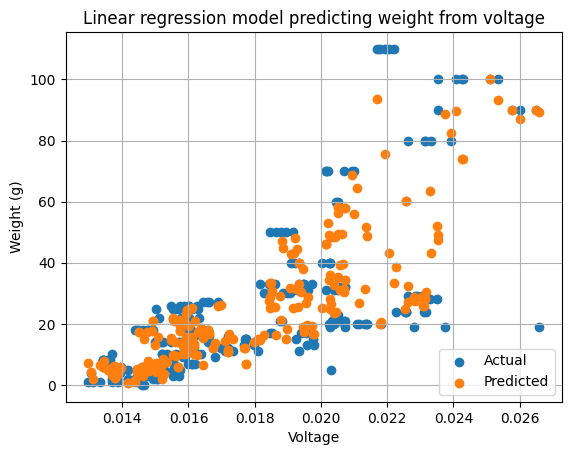

In [8]:
df=df.dropna()
X=np.array([])
y=np.array([])
for i in range(len(keys)):
    key=keys[i]
    vals=df[key].values
    vals=low_pass(vals)
    X=np.concatenate([X,vals])
    y=np.concatenate([y,np.array([int(key) for j in range(len(vals))])])
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.2, random_state=42) #this splits

#train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#work out how good the model is on the train data
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

#work out how good the model is on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test,y_test,label="Actual")
plt.scatter(X_test,y_pred,label="Predicted")
plt.grid(1)
plt.legend(loc="lower right")
plt.xlabel("Voltage")
plt.ylabel("Weight (g)")
plt.title("Linear regression model predicting weight from voltage")

In [57]:
tree = model.estimators_[0].tree_

# Print a manual decision tree to hardcode in CircuitPython
def extract_rules(tree, feature_names=["Water", "Sunlight"]):
    """Extracts simple if-else rules from the tree"""
    rules = []
    
    def traverse(node, condition=""):
        if tree.children_left[node] == -1:  # Leaf node
            rules.append(f"{condition} -> Predict: {tree.value[node][0][0]}")
            return
        
        feature = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        
        left_condition = f"{condition}if {feature} <= {threshold:.5f} "
        right_condition = f"{condition}if {feature} > {threshold:.5f} "
        
        traverse(tree.children_left[node], left_condition)
        traverse(tree.children_right[node], right_condition)
    
    traverse(0)
    return rules

rules = extract_rules(tree)

print("\nExtracted Rules for CircuitPython:")
for rule in rules:
    print(rule)



Extracted Rules for CircuitPython:
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water <= 0.01463  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water <= 0.01470 if Water <= 0.01465  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water <= 0.01470 if Water > 0.01465  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water > 0.01470  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water > 0.01476  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water > 0.01479  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water > 0.01753  -> Predict: 30.0
if Water <= 0.02029 if Water

## Neural network

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.2, random_state=42) #this splits
X=np.array([])
y=np.array([])
for i in range(len(keys)):
    key=keys[i]
    vals=df[key].values
    vals=low_pass(vals,alpha=0.7)
    X=np.concatenate([X,vals])
    y=np.concatenate([y,np.array([int(key) for j in range(len(vals))])])
print(X.shape,y.shape)
nan_indices = np.isnan(X) | np.isnan(y)
# Remove rows with NaN values
X = X[~nan_indices] 
y = y[~nan_indices] 
X_train_tensor = torch.tensor(X, dtype=torch.float32).reshape((-1,1))
y_train_tensor = torch.tensor(y, dtype=torch.float32).reshape((-1,1))
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)
print(X_train_split.shape,y_train_split.shape)
if np.any(np.isnan(X)) or np.any(np.isnan(y)):
    print("Data contains NaN values!")
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 21)  # 1 input feature, 64 output features
        self.fc2 = nn.Linear(21, 5)  # 64 input features, 32 output features
        self.fc3 = nn.Linear(5, 1)  # 32 input features, 1 output (weight in kg)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = SimpleNN().float()
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 300000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    predictions = model(X_train_split)
    loss = criterion(predictions, y_train_split)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
    optimizer.step()
    
    # Validation
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_predictions = model(X_train_split)
        val_loss = criterion(val_predictions, y_train_split)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, TRain Loss: {val_loss.item():.4f}")

# Test the model with a new value (example)
model.eval()
new_value = torch.tensor([[0.5]])  # Replace with new analog input
predicted_weight = model(new_value)
print(f"Predicted weight for input {new_value.item()}: {predicted_weight.item():.2f} g")


(1218,) (1218,)
torch.Size([974, 1]) torch.Size([974, 1])
Epoch [1000/300000], Loss: 796.5611, TRain Loss: 795.7589
Epoch [2000/300000], Loss: 720.8030, TRain Loss: 720.8005
Epoch [3000/300000], Loss: 716.5988, TRain Loss: 716.5913
Epoch [4000/300000], Loss: 699.0801, TRain Loss: 699.0522
Epoch [5000/300000], Loss: 661.1923, TRain Loss: 661.1509
Epoch [6000/300000], Loss: 622.0807, TRain Loss: 622.0440
Epoch [7000/300000], Loss: 587.6133, TRain Loss: 587.5811
Epoch [8000/300000], Loss: 557.5247, TRain Loss: 557.4966
Epoch [9000/300000], Loss: 531.3604, TRain Loss: 531.3361
Epoch [10000/300000], Loss: 508.6560, TRain Loss: 508.6349
Epoch [11000/300000], Loss: 488.9783, TRain Loss: 488.9600
Epoch [12000/300000], Loss: 471.9393, TRain Loss: 471.9235
Epoch [13000/300000], Loss: 457.1941, TRain Loss: 457.1804
Epoch [14000/300000], Loss: 444.4391, TRain Loss: 444.4273
Epoch [15000/300000], Loss: 433.4093, TRain Loss: 433.3991
Epoch [16000/300000], Loss: 423.8737, TRain Loss: 423.8649
Epoch [

Text(0.5, 1.0, 'Neural network regression model predicting weight from voltage')

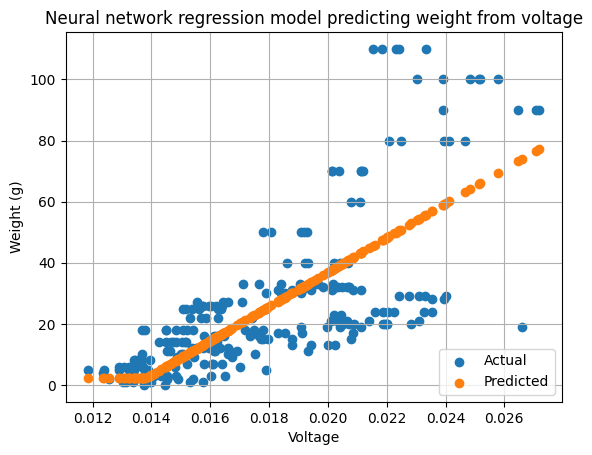

In [13]:
val_predictions = model(X_val_split)

plt.scatter(X_val_split.detach().numpy(),y_val_split.detach().numpy(),label="Actual")
plt.scatter(X_val_split.detach().numpy(),val_predictions.detach().numpy(),label="Predicted")
plt.grid(1)
plt.legend(loc="lower right")
plt.xlabel("Voltage")
plt.ylabel("Weight (g)")
plt.title("Neural network regression model predicting weight from voltage")


In [14]:
weights_biases = {
    "fc1": {
        "weights": model.fc1.weight.detach().numpy().T.tolist(),
        "biases": model.fc1.bias.detach().numpy().tolist()
    },
    "fc2": {
        "weights": model.fc2.weight.detach().numpy().T.tolist(),
        "biases": model.fc2.bias.detach().numpy().tolist()
    },
    "fc3": {
        "weights": model.fc3.weight.detach().numpy().T.tolist(),
        "biases": model.fc3.bias.detach().numpy().tolist()
    }
}
i=1
for layer, params in weights_biases.items():
    print("model.w"+str(i)+"=np.array(",params['weights'],")")
    print("model.b"+str(i)+"=np.array(",params['biases'],")")
    i+=1


model.w1=np.array( [[-0.7000062465667725, -0.8305444121360779, 0.27922260761260986, -0.8159389495849609, -5.315109729766846, 0.6620736122131348, 9.289552688598633, 0.8159716129302979, -0.03547012805938721, -0.43851470947265625, 2.450671911239624, 8.48858642578125, 0.494533896446228, 1.0367826223373413, -5.759180068969727, -0.02212989330291748, 0.7692402601242065, 0.7584546804428101, 9.554434776306152, -1.6320135593414307, 0.18156041204929352]] )
model.b1=np.array( [-0.9941424131393433, 1.120008945465088, -0.11176586151123047, -0.18242812156677246, 0.5178545713424683, 0.7264984846115112, 0.005280154291540384, -0.6862404346466064, -0.7059328556060791, -0.5621237754821777, 0.07116126269102097, -0.018869219347834587, -0.17596280574798584, 0.8604576587677002, 0.6344777345657349, -0.8804788589477539, 0.2781198024749756, -0.7249699831008911, 0.1345357447862625, 0.7950783371925354, 1.3161567449569702] )
model.w2=np.array( [[0.0686660185456276, 0.2144206166267395, 0.18679910898208618, -0.035134

In [68]:
print(X[0:100].astype(np.float32).tolist())
print(X[0:100].tolist())

[0.014502200298011303, 0.014743899926543236, 0.014719730243086815, 0.014617406763136387, 0.014605886302888393, 0.0145955178886652, 0.014666745439171791, 0.01465029176324606, 0.014716042205691338, 0.01477521751075983, 0.014747915789484978, 0.01440107449889183, 0.014411186799407005, 0.014420288614928722, 0.014428479596972466, 0.014435851946473122, 0.014523046091198921, 0.014520961791276932, 0.014519085176289082, 0.014517396688461304, 0.014677007682621479, 0.014740086160600185, 0.014796857722103596, 0.014767392538487911, 0.014660302549600601, 0.01504732295870781, 0.014992810785770416, 0.014299205504357815, 0.014319504611194134, 0.01772489957511425, 0.017483189702033997, 0.017265651375055313, 0.01706986501812935, 0.0168936587870121, 0.016735073179006577, 0.01667291671037674, 0.01669754460453987, 0.0165585707873106, 0.015788957476615906, 0.01574084162712097, 0.014650163240730762, 0.014715926721692085, 0.014694553799927235, 0.01475587859749794, 0.014811070635914803, 0.014860743656754494, 0.0

## crossover to CP check

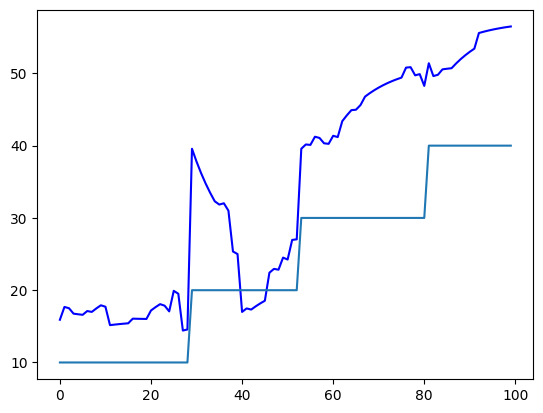

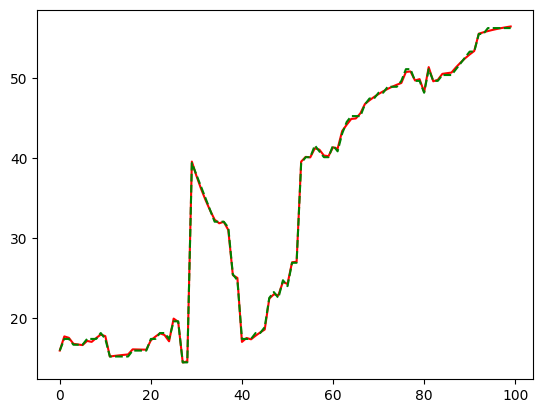

In [140]:
class SimpleNN_CP:
    def __init__(self):
        self.w1=np.zeros((1,21))
        self.b1=np.zeros((21))
        
        self.w2=np.zeros((21,5))
        self.b2=np.zeros((5))
        
        self.w3=np.zeros((5,1))
        self.b3=np.zeros((1))
    def relu(self,x):
        return np.maximum(x,0)#torch.relu(torch.tensor(x)).detach().numpy()#
    def forward(self,x):
        h=self.relu(np.dot(x,self.w1)+self.b1)
        h=self.relu(np.dot(h,self.w2)+self.b2)
        h=np.dot(h,self.w3)+self.b3
        return h
    def reshape(self):
        self.w1=np.around(self.w1.reshape((1,21)),4)
        self.b1=np.around(self.b1.reshape((1,21)),4)
        self.w2=np.around(self.w2.reshape((21,5)),4)
        self.b2=np.around(self.b2.reshape((1,5)),4)
        self.w3=np.around(self.w3.reshape((5,1)),4)
        self.b3=np.around(self.b3.reshape((1,1)),4)

modelcp=SimpleNN_CP()
modelcp.w1=model.fc1.weight.detach().numpy().T.astype(np.float32)
modelcp.b1=model.fc1.bias.detach().numpy().T.astype(np.float32)
modelcp.w2=model.fc2.weight.detach().numpy().T.astype(np.float32)
modelcp.b2=model.fc2.bias.detach().numpy().T.astype(np.float32)
modelcp.w3=model.fc3.weight.detach().numpy().T.astype(np.float32)
modelcp.b3=model.fc3.bias.detach().numpy().T.astype(np.float32)
modelcp.reshape()

X_test=[0.014502200298011303, 0.014743899926543236, 0.014719730243086815, 0.014617406763136387, 0.014605886302888393, 0.0145955178886652, 0.014666745439171791, 0.01465029176324606, 0.014716042205691338, 0.01477521751075983, 0.014747915789484978, 0.01440107449889183, 0.014411186799407005, 0.014420288614928722, 0.014428479596972466, 0.014435851946473122, 0.014523046091198921, 0.014520961791276932, 0.014519085176289082, 0.014517396688461304, 0.014677007682621479, 0.014740086160600185, 0.014796857722103596, 0.014767392538487911, 0.014660302549600601, 0.01504732295870781, 0.014992810785770416, 0.014299205504357815, 0.014319504611194134, 0.01772489957511425, 0.017483189702033997, 0.017265651375055313, 0.01706986501812935, 0.0168936587870121, 0.016735073179006577, 0.01667291671037674, 0.01669754460453987, 0.0165585707873106, 0.015788957476615906, 0.01574084162712097, 0.014650163240730762, 0.014715926721692085, 0.014694553799927235, 0.01475587859749794, 0.014811070635914803, 0.014860743656754494, 0.015388859435915947, 0.015461323782801628, 0.015445970930159092, 0.015673864632844925, 0.01563725806772709, 0.01600715145468712, 0.016017787158489227, 0.01772489957511425, 0.01780546084046364, 0.017797404900193214, 0.01795128360390663, 0.01792864501476288, 0.017827700823545456, 0.01781742088496685, 0.017969299107789993, 0.017944859340786934, 0.018245132640004158, 0.01835423894226551, 0.018452435731887817, 0.018460242077708244, 0.018547838553786278, 0.018707243725657463, 0.018770139664411545, 0.018826745450496674, 0.01887769065797329, 0.01892354153096676, 0.01896480843424797, 0.019001947715878487, 0.019035372883081436, 0.019065454602241516, 0.019253669306635857, 0.0192619226872921, 0.01910822093486786, 0.019131017848849297, 0.018909836187958717, 0.019336199387907982, 0.019094500690698624, 0.019118670374155045, 0.019220992922782898, 0.01923251338303089, 0.01924288272857666, 0.019332783296704292, 0.019413696601986885, 0.01948651671409607, 0.01955205388367176, 0.019611038267612457, 0.019905826076865196, 0.01992943324148655, 0.019950678572058678, 0.019969802349805832, 0.019987011328339577, 0.02000250108540058, 0.020016439259052277, 0.020028986036777496]
y_test=[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]

preds=modelcp.forward(np.array(X_test).reshape((len(X_test),1)))

plt.plot(preds,c="b")
plt.plot(y_test)
plt.show()

a = torch.relu(model.fc1(torch.tensor(X_test).reshape(100,1)))
b = np.maximum((np.dot(np.around(np.array(X_test),4).reshape((100,1)), modelcp.w1) + modelcp.b1).astype(np.float32),0)

a = model.fc2(a)
b = (np.dot(np.around(b,4), modelcp.w2) + modelcp.b2).astype(np.float32)

a = model.fc3(torch.relu(a))
b = np.dot(np.maximum(b,0), modelcp.w3) + modelcp.b3

plt.plot(a.detach().numpy().flatten().tolist(),c="r")
plt.plot(b.flatten().tolist(),"--",c="g")
plt.show()

In [117]:
print(model.fc1.weight)
print(np.around(model.fc1.weight.detach().numpy(),4))

Parameter containing:
tensor([[ 0.7685],
        [ 0.6293],
        [-0.1969],
        [11.4406],
        [ 0.6209],
        [ 0.5512],
        [10.8053],
        [-0.8079],
        [10.0060],
        [ 0.3465],
        [10.7566],
        [ 0.9841],
        [ 0.7739],
        [10.8332],
        [12.0078],
        [ 0.6142],
        [10.4769],
        [11.2280],
        [11.0797],
        [ 0.9681],
        [10.5529]], requires_grad=True)
[[ 0.7685]
 [ 0.6293]
 [-0.1969]
 [11.4406]
 [ 0.6209]
 [ 0.5512]
 [10.8053]
 [-0.8079]
 [10.006 ]
 [ 0.3465]
 [10.7566]
 [ 0.9841]
 [ 0.7739]
 [10.8332]
 [12.0078]
 [ 0.6142]
 [10.4769]
 [11.228 ]
 [11.0797]
 [ 0.9681]
 [10.5529]]
